# Feature Engineering for Persian Banking Sentiment Analysis

This notebook demonstrates the feature engineering pipeline for Persian banking sentiment analysis, including:
- TF-IDF feature extraction
- Word2Vec embeddings
- BERT embeddings
- Feature analysis and visualization

## Overview
We'll explore different text representation methods and their effectiveness for Persian sentiment classification.

In [12]:
# Import necessary libraries
import sys
import os
from pathlib import Path

# Add project root to path
project_root = Path.cwd().parent
sys.path.append(str(project_root))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Configure matplotlib for Persian text
plt.rcParams['font.family'] = 'Arial Unicode MS'
plt.rcParams['font.size'] = 12

In [13]:
# Load configuration
from config import (
    FILE_PATHS, FEATURE_CONFIG, 
    PROCESSED_DATA_DIR, RESULTS_DIR, FIGURES_DIR
)

# Load preprocessed data
labeled_data_path = FILE_PATHS['labeled_comments']
df = pd.read_csv(labeled_data_path)

print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print("\nSentiment distribution:")
print(df['sentiment_label'].value_counts())

Dataset shape: (1688, 15)
Columns: ['id', 'app_package', 'app_name', 'user', 'comment', 'rating', 'likes', 'total_votes', 'date', 'version_code', 'from_developer', 'is_edited', 'scraped_at', 'sentiment_label', 'metadata']

Sentiment distribution:
sentiment_label
negative    1060
positive     486
neutral      142
Name: count, dtype: int64


## 1. TF-IDF Feature Extraction

TF-IDF (Term Frequency-Inverse Document Frequency) is a statistical measure that evaluates how important a word is to a document in a collection of documents.

In [14]:
from src.features.tfidf_extractor import PersianTfidfExtractor

# Initialize TF-IDF pipeline
tfidf_config = FEATURE_CONFIG['tfidf']
tfidf_pipeline = PersianTfidfExtractor(config=tfidf_config)

# Extract TF-IDF features
print("Extracting TF-IDF features...")
tfidf_features = tfidf_pipeline.fit_transform(df['comment'].tolist(), df['sentiment_label'].tolist())

print(f"TF-IDF feature matrix shape: {tfidf_features.shape}")
print(f"Vocabulary size: {len(tfidf_pipeline.vectorizer.vocabulary_)}")
print(f"Feature names: {len(tfidf_pipeline.vectorizer.get_feature_names_out())}")

2025-09-01 16:51:49,586 - src.features.tfidf_extractor - INFO - Starting TF-IDF fitting and transformation...
2025-09-01 16:51:49,590 - src.features.tfidf_extractor - INFO - Created TF-IDF vectorizer with config: {'max_features': 10000, 'min_df': 2, 'max_df': 0.8, 'ngram_range': (1, 2), 'use_idf': True, 'smooth_idf': True}


Extracting TF-IDF features...


2025-09-01 16:51:49,779 - src.features.tfidf_extractor - INFO - TF-IDF extraction completed in 0.18 seconds
2025-09-01 16:51:49,784 - src.features.tfidf_extractor - INFO - Feature matrix shape: (1688, 2008)
2025-09-01 16:51:49,788 - src.features.tfidf_extractor - INFO - Vocabulary size: 2008
2025-09-01 16:51:49,792 - src.features.tfidf_extractor - INFO - Matrix sparsity: 99.23%


TF-IDF feature matrix shape: (1688, 2008)
Vocabulary size: 2008
Feature names: 2008


2025-09-01 16:51:50,494 - matplotlib.font_manager - WARNING - findfont: Font family 'Arial Unicode MS' not found.
2025-09-01 16:51:50,499 - matplotlib.font_manager - WARNING - findfont: Font family 'Arial Unicode MS' not found.
2025-09-01 16:51:50,508 - matplotlib.font_manager - WARNING - findfont: Font family 'Arial Unicode MS' not found.
2025-09-01 16:51:50,512 - matplotlib.font_manager - WARNING - findfont: Font family 'Arial Unicode MS' not found.
2025-09-01 16:51:50,523 - matplotlib.font_manager - WARNING - findfont: Font family 'Arial Unicode MS' not found.
2025-09-01 16:51:50,529 - matplotlib.font_manager - WARNING - findfont: Font family 'Arial Unicode MS' not found.
2025-09-01 16:51:50,536 - matplotlib.font_manager - WARNING - findfont: Font family 'Arial Unicode MS' not found.
2025-09-01 16:51:50,544 - matplotlib.font_manager - WARNING - findfont: Font family 'Arial Unicode MS' not found.
2025-09-01 16:51:50,553 - matplotlib.font_manager - WARNING - findfont: Font family 'Ari

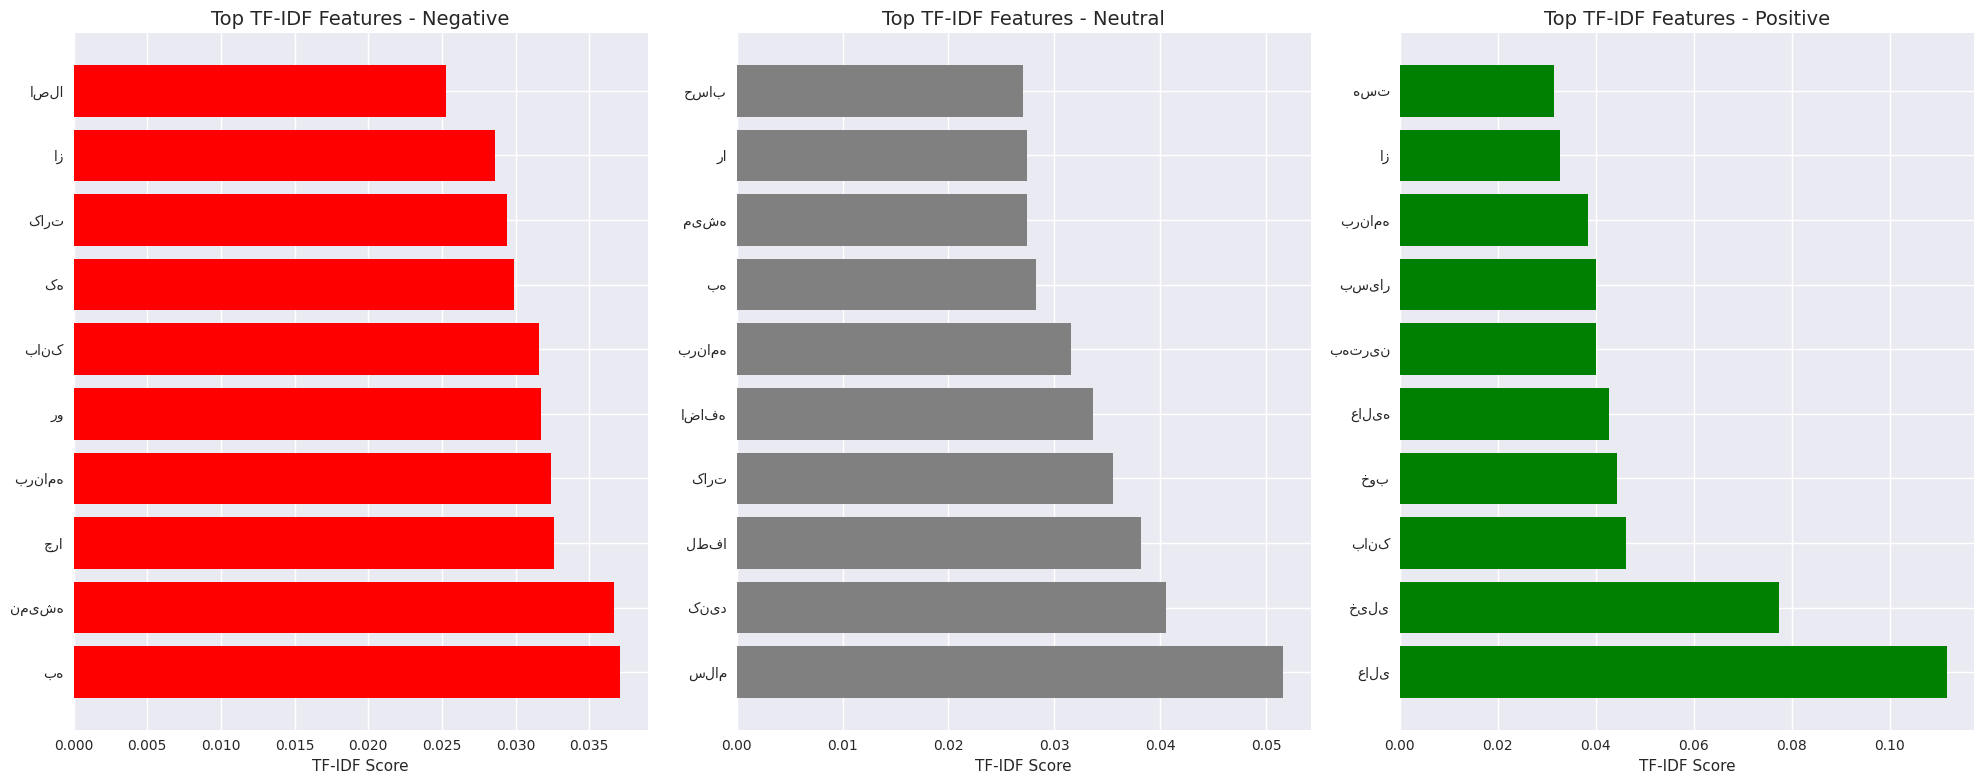

In [15]:
# Analyze TF-IDF features
feature_names = tfidf_pipeline.vectorizer.get_feature_names_out()
tfidf_matrix = tfidf_features.toarray()

# Get top features by sentiment
sentiment_labels = df['sentiment_label'].values

def get_top_features_by_sentiment(tfidf_matrix, feature_names, labels, n_top=10):
    """Get top TF-IDF features for each sentiment class"""
    sentiment_features = {}
    
    for sentiment in ['negative', 'neutral', 'positive']:
        mask = labels == sentiment
        if mask.sum() > 0:
            # Calculate mean TF-IDF scores for this sentiment
            sentiment_scores = tfidf_matrix[mask].mean(axis=0)
            # Get top features
            top_indices = np.argsort(sentiment_scores)[-n_top:][::-1]
            sentiment_features[sentiment] = [
                (feature_names[i], sentiment_scores[i]) 
                for i in top_indices
            ]
    
    return sentiment_features

top_features = get_top_features_by_sentiment(tfidf_matrix, feature_names, sentiment_labels)

# Visualize top features
fig, axes = plt.subplots(1, 3, figsize=(20, 8))
colors = ['red', 'gray', 'green']

for idx, (sentiment, features) in enumerate(top_features.items()):
    words, scores = zip(*features)
    
    axes[idx].barh(range(len(words)), scores, color=colors[idx])
    axes[idx].set_yticks(range(len(words)))
    axes[idx].set_yticklabels(words, fontsize=10)
    axes[idx].set_title(f'Top TF-IDF Features - {sentiment.capitalize()}', fontsize=14)
    axes[idx].set_xlabel('TF-IDF Score')

plt.tight_layout()
plt.show()

## 2. Word2Vec Embeddings

Word2Vec creates dense vector representations of words based on their context in the corpus.

In [16]:
from src.features.word2vec_trainer import PersianWord2VecTrainer

# Initialize Word2Vec trainer
w2v_config = FEATURE_CONFIG['word2vec']
w2v_trainer = PersianWord2VecTrainer(config=w2v_config)

# Prepare text data for Word2Vec training
texts = df['comment'].tolist()

# Train Word2Vec model
print("Training Word2Vec model...")
w2v_model = w2v_trainer.train_model(df['comment'].tolist())

print(f"Word2Vec model vocabulary size: {len(w2v_model.wv.key_to_index)}")
print(f"Vector dimensions: {w2v_model.vector_size}")

2025-09-01 16:51:53,508 - src.features.word2vec_trainer - INFO - Starting Word2Vec training...
2025-09-01 16:51:53,513 - gensim.utils - INFO - Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=200, alpha=0.025>', 'datetime': '2025-09-01T16:51:53.513765', 'gensim': '4.3.3', 'python': '3.11.13 | packaged by Anaconda, Inc. | (main, Jun  5 2025, 13:03:15) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.26100-SP0', 'event': 'created'}
2025-09-01 16:51:53,517 - src.features.word2vec_trainer - INFO - Created Word2Vec model with config: {'vector_size': 200, 'window': 5, 'min_count': 2, 'workers': 4, 'epochs': 100, 'sg': 1}
2025-09-01 16:51:53,520 - src.features.word2vec_trainer - INFO - Building vocabulary...
2025-09-01 16:51:53,524 - gensim.models.word2vec - INFO - collecting all words and their counts
2025-09-01 16:51:53,527 - gensim.models.word2vec - WARNING - Each 'sentences' item should be a list of words (usually unicode strings). First item here is instead pl

Training Word2Vec model...


2025-09-01 16:51:54,001 - gensim.models.word2vec - INFO - EPOCH 0: training on 168587 raw words (32744 effective words) took 0.3s, 116201 effective words/s
2025-09-01 16:51:54,273 - gensim.models.word2vec - INFO - EPOCH 1: training on 168587 raw words (32643 effective words) took 0.3s, 126482 effective words/s
2025-09-01 16:51:54,528 - gensim.models.word2vec - INFO - EPOCH 2: training on 168587 raw words (32658 effective words) took 0.2s, 141309 effective words/s
2025-09-01 16:51:54,838 - gensim.models.word2vec - INFO - EPOCH 3: training on 168587 raw words (32640 effective words) took 0.3s, 109439 effective words/s
2025-09-01 16:51:55,235 - gensim.models.word2vec - INFO - EPOCH 4: training on 168587 raw words (32679 effective words) took 0.4s, 85549 effective words/s
2025-09-01 16:51:55,819 - gensim.models.word2vec - INFO - EPOCH 5: training on 168587 raw words (33027 effective words) took 0.5s, 65476 effective words/s
2025-09-01 16:51:56,249 - gensim.models.word2vec - INFO - EPOCH 6:

Epoch 10, Loss: 0.0


2025-09-01 16:51:58,074 - gensim.models.word2vec - INFO - EPOCH 10: training on 168587 raw words (33012 effective words) took 0.3s, 130676 effective words/s
2025-09-01 16:51:58,540 - gensim.models.word2vec - INFO - EPOCH 11: training on 168587 raw words (33068 effective words) took 0.4s, 74109 effective words/s
2025-09-01 16:51:59,041 - gensim.models.word2vec - INFO - EPOCH 12: training on 168587 raw words (32528 effective words) took 0.5s, 69868 effective words/s
2025-09-01 16:51:59,469 - gensim.models.word2vec - INFO - EPOCH 13: training on 168587 raw words (32600 effective words) took 0.4s, 86069 effective words/s
2025-09-01 16:51:59,831 - gensim.models.word2vec - INFO - EPOCH 14: training on 168587 raw words (32522 effective words) took 0.3s, 94182 effective words/s
2025-09-01 16:52:00,084 - gensim.models.word2vec - INFO - EPOCH 15: training on 168587 raw words (32781 effective words) took 0.2s, 137829 effective words/s
2025-09-01 16:52:00,440 - gensim.models.word2vec - INFO - EPOC

Epoch 20, Loss: 0.0


2025-09-01 16:52:01,908 - gensim.models.word2vec - INFO - EPOCH 20: training on 168587 raw words (32728 effective words) took 0.4s, 76601 effective words/s
2025-09-01 16:52:02,235 - gensim.models.word2vec - INFO - EPOCH 21: training on 168587 raw words (32852 effective words) took 0.3s, 114971 effective words/s
2025-09-01 16:52:02,540 - gensim.models.word2vec - INFO - EPOCH 22: training on 168587 raw words (32638 effective words) took 0.3s, 114053 effective words/s
2025-09-01 16:52:02,761 - gensim.models.word2vec - INFO - EPOCH 23: training on 168587 raw words (32782 effective words) took 0.2s, 158554 effective words/s
2025-09-01 16:52:03,039 - gensim.models.word2vec - INFO - EPOCH 24: training on 168587 raw words (32824 effective words) took 0.3s, 123403 effective words/s
2025-09-01 16:52:03,296 - gensim.models.word2vec - INFO - EPOCH 25: training on 168587 raw words (32847 effective words) took 0.2s, 134667 effective words/s
2025-09-01 16:52:03,557 - gensim.models.word2vec - INFO - E

Epoch 30, Loss: 0.0


2025-09-01 16:52:04,562 - gensim.models.word2vec - INFO - EPOCH 30: training on 168587 raw words (32785 effective words) took 0.3s, 123655 effective words/s
2025-09-01 16:52:04,791 - gensim.models.word2vec - INFO - EPOCH 31: training on 168587 raw words (32710 effective words) took 0.2s, 151583 effective words/s
2025-09-01 16:52:05,027 - gensim.models.word2vec - INFO - EPOCH 32: training on 168587 raw words (32818 effective words) took 0.2s, 146895 effective words/s
2025-09-01 16:52:05,292 - gensim.models.word2vec - INFO - EPOCH 33: training on 168587 raw words (32852 effective words) took 0.3s, 131183 effective words/s
2025-09-01 16:52:05,562 - gensim.models.word2vec - INFO - EPOCH 34: training on 168587 raw words (32791 effective words) took 0.3s, 128374 effective words/s
2025-09-01 16:52:05,786 - gensim.models.word2vec - INFO - EPOCH 35: training on 168587 raw words (32699 effective words) took 0.2s, 159944 effective words/s
2025-09-01 16:52:06,016 - gensim.models.word2vec - INFO - 

Epoch 40, Loss: 0.0


2025-09-01 16:52:07,035 - gensim.models.word2vec - INFO - EPOCH 40: training on 168587 raw words (32825 effective words) took 0.3s, 127266 effective words/s
2025-09-01 16:52:07,270 - gensim.models.word2vec - INFO - EPOCH 41: training on 168587 raw words (32721 effective words) took 0.2s, 150282 effective words/s
2025-09-01 16:52:07,532 - gensim.models.word2vec - INFO - EPOCH 42: training on 168587 raw words (32946 effective words) took 0.2s, 133662 effective words/s
2025-09-01 16:52:07,770 - gensim.models.word2vec - INFO - EPOCH 43: training on 168587 raw words (32640 effective words) took 0.2s, 142975 effective words/s
2025-09-01 16:52:08,049 - gensim.models.word2vec - INFO - EPOCH 44: training on 168587 raw words (32669 effective words) took 0.3s, 123143 effective words/s
2025-09-01 16:52:08,280 - gensim.models.word2vec - INFO - EPOCH 45: training on 168587 raw words (32633 effective words) took 0.2s, 149464 effective words/s
2025-09-01 16:52:08,556 - gensim.models.word2vec - INFO - 

Epoch 50, Loss: 0.0


2025-09-01 16:52:09,591 - gensim.models.word2vec - INFO - EPOCH 50: training on 168587 raw words (32770 effective words) took 0.2s, 140545 effective words/s
2025-09-01 16:52:09,860 - gensim.models.word2vec - INFO - EPOCH 51: training on 168587 raw words (32916 effective words) took 0.2s, 143669 effective words/s
2025-09-01 16:52:10,103 - gensim.models.word2vec - INFO - EPOCH 52: training on 168587 raw words (32646 effective words) took 0.2s, 141661 effective words/s
2025-09-01 16:52:10,364 - gensim.models.word2vec - INFO - EPOCH 53: training on 168587 raw words (32498 effective words) took 0.2s, 130588 effective words/s
2025-09-01 16:52:10,629 - gensim.models.word2vec - INFO - EPOCH 54: training on 168587 raw words (32894 effective words) took 0.3s, 130458 effective words/s
2025-09-01 16:52:10,837 - gensim.models.word2vec - INFO - EPOCH 55: training on 168587 raw words (32660 effective words) took 0.2s, 165894 effective words/s
2025-09-01 16:52:11,024 - gensim.models.word2vec - INFO - 

Epoch 60, Loss: 0.0


2025-09-01 16:52:11,910 - gensim.models.word2vec - INFO - EPOCH 60: training on 168587 raw words (32766 effective words) took 0.2s, 161086 effective words/s
2025-09-01 16:52:12,158 - gensim.models.word2vec - INFO - EPOCH 61: training on 168587 raw words (33124 effective words) took 0.2s, 140347 effective words/s
2025-09-01 16:52:12,430 - gensim.models.word2vec - INFO - EPOCH 62: training on 168587 raw words (32719 effective words) took 0.3s, 127074 effective words/s
2025-09-01 16:52:12,630 - gensim.models.word2vec - INFO - EPOCH 63: training on 168587 raw words (33058 effective words) took 0.2s, 177887 effective words/s
2025-09-01 16:52:12,926 - gensim.models.word2vec - INFO - EPOCH 64: training on 168587 raw words (32720 effective words) took 0.3s, 114106 effective words/s
2025-09-01 16:52:13,184 - gensim.models.word2vec - INFO - EPOCH 65: training on 168587 raw words (32624 effective words) took 0.2s, 133327 effective words/s
2025-09-01 16:52:13,433 - gensim.models.word2vec - INFO - 

Epoch 70, Loss: 0.0


2025-09-01 16:52:14,415 - gensim.models.word2vec - INFO - EPOCH 70: training on 168587 raw words (32912 effective words) took 0.2s, 133150 effective words/s
2025-09-01 16:52:14,664 - gensim.models.word2vec - INFO - EPOCH 71: training on 168587 raw words (32856 effective words) took 0.2s, 137821 effective words/s
2025-09-01 16:52:14,855 - gensim.models.word2vec - INFO - EPOCH 72: training on 168587 raw words (32563 effective words) took 0.2s, 183413 effective words/s
2025-09-01 16:52:15,029 - gensim.models.word2vec - INFO - EPOCH 73: training on 168587 raw words (32827 effective words) took 0.2s, 196750 effective words/s
2025-09-01 16:52:15,242 - gensim.models.word2vec - INFO - EPOCH 74: training on 168587 raw words (32725 effective words) took 0.2s, 162982 effective words/s
2025-09-01 16:52:15,464 - gensim.models.word2vec - INFO - EPOCH 75: training on 168587 raw words (32401 effective words) took 0.2s, 152444 effective words/s
2025-09-01 16:52:15,701 - gensim.models.word2vec - INFO - 

Epoch 80, Loss: 0.0


2025-09-01 16:52:16,476 - gensim.models.word2vec - INFO - EPOCH 80: training on 168587 raw words (32608 effective words) took 0.2s, 143482 effective words/s
2025-09-01 16:52:16,723 - gensim.models.word2vec - INFO - EPOCH 81: training on 168587 raw words (32868 effective words) took 0.2s, 141313 effective words/s
2025-09-01 16:52:16,960 - gensim.models.word2vec - INFO - EPOCH 82: training on 168587 raw words (32726 effective words) took 0.2s, 143886 effective words/s
2025-09-01 16:52:17,191 - gensim.models.word2vec - INFO - EPOCH 83: training on 168587 raw words (32665 effective words) took 0.2s, 151110 effective words/s
2025-09-01 16:52:17,472 - gensim.models.word2vec - INFO - EPOCH 84: training on 168587 raw words (32649 effective words) took 0.3s, 122774 effective words/s
2025-09-01 16:52:17,736 - gensim.models.word2vec - INFO - EPOCH 85: training on 168587 raw words (32600 effective words) took 0.2s, 134359 effective words/s
2025-09-01 16:52:17,964 - gensim.models.word2vec - INFO - 

Epoch 90, Loss: 0.0


2025-09-01 16:52:18,831 - gensim.models.word2vec - INFO - EPOCH 90: training on 168587 raw words (32723 effective words) took 0.3s, 129160 effective words/s
2025-09-01 16:52:19,077 - gensim.models.word2vec - INFO - EPOCH 91: training on 168587 raw words (32731 effective words) took 0.2s, 140395 effective words/s
2025-09-01 16:52:19,293 - gensim.models.word2vec - INFO - EPOCH 92: training on 168587 raw words (32434 effective words) took 0.2s, 159674 effective words/s
2025-09-01 16:52:19,526 - gensim.models.word2vec - INFO - EPOCH 93: training on 168587 raw words (32579 effective words) took 0.2s, 147964 effective words/s
2025-09-01 16:52:19,789 - gensim.models.word2vec - INFO - EPOCH 94: training on 168587 raw words (32831 effective words) took 0.3s, 130162 effective words/s
2025-09-01 16:52:20,025 - gensim.models.word2vec - INFO - EPOCH 95: training on 168587 raw words (32599 effective words) took 0.2s, 146374 effective words/s
2025-09-01 16:52:20,229 - gensim.models.word2vec - INFO - 

Epoch 100, Loss: 0.0
Word2Vec model vocabulary size: 132
Vector dimensions: 200


In [17]:
# Analyze Word2Vec embeddings
def get_document_embeddings(texts, w2v_model):
    """Get document embeddings by averaging word vectors"""
    embeddings = []
    
    for text in texts:
        words = text.split()
        word_vectors = []
        
        for word in words:
            if word in w2v_model.wv:
                word_vectors.append(w2v_model.wv[word])
        
        if word_vectors:
            # Average word vectors
            doc_embedding = np.mean(word_vectors, axis=0)
        else:
            # Zero vector if no words found
            doc_embedding = np.zeros(w2v_model.vector_size)
        
        embeddings.append(doc_embedding)
    
    return np.array(embeddings)

# Get document embeddings
doc_embeddings = get_document_embeddings(texts, w2v_model)
print(f"Document embeddings shape: {doc_embeddings.shape}")

Document embeddings shape: (1688, 200)


Applying t-SNE for visualization...


2025-09-01 16:52:35,118 - matplotlib.font_manager - WARNING - findfont: Font family 'Arial Unicode MS' not found.
2025-09-01 16:52:35,122 - matplotlib.font_manager - WARNING - findfont: Font family 'Arial Unicode MS' not found.
2025-09-01 16:52:35,131 - matplotlib.font_manager - WARNING - findfont: Font family 'Arial Unicode MS' not found.
2025-09-01 16:52:35,134 - matplotlib.font_manager - WARNING - findfont: Font family 'Arial Unicode MS' not found.
2025-09-01 16:52:35,137 - matplotlib.font_manager - WARNING - findfont: Font family 'Arial Unicode MS' not found.
2025-09-01 16:52:35,139 - matplotlib.font_manager - WARNING - findfont: Font family 'Arial Unicode MS' not found.
2025-09-01 16:52:35,142 - matplotlib.font_manager - WARNING - findfont: Font family 'Arial Unicode MS' not found.
2025-09-01 16:52:35,148 - matplotlib.font_manager - WARNING - findfont: Font family 'Arial Unicode MS' not found.
2025-09-01 16:52:35,151 - matplotlib.font_manager - WARNING - findfont: Font family 'Ari

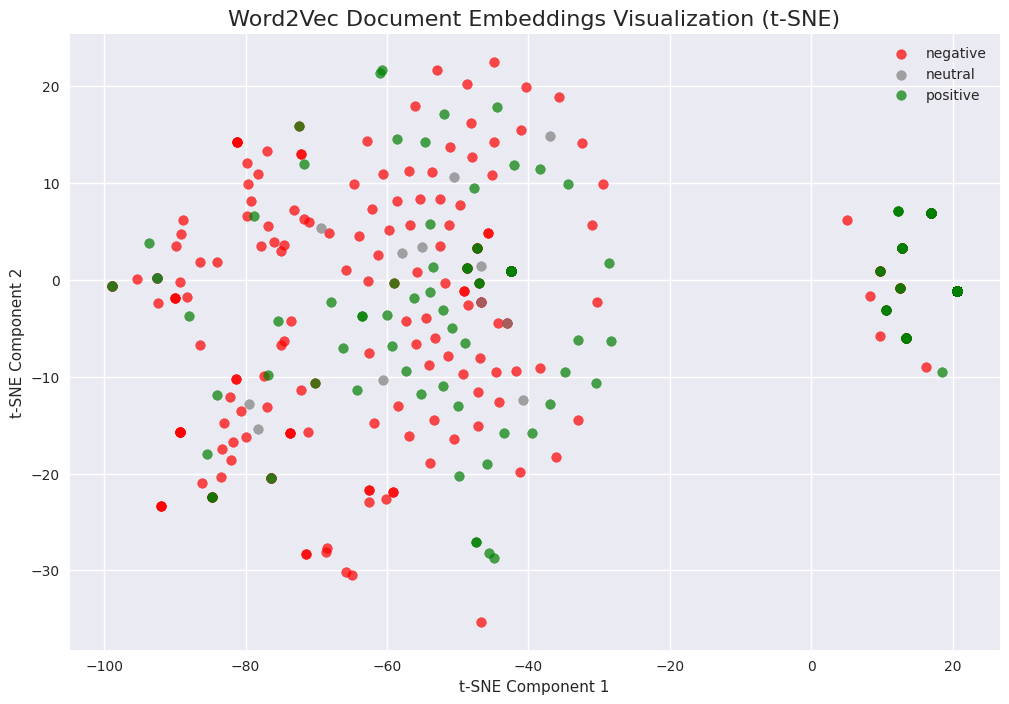

In [18]:
# Visualize Word2Vec embeddings using t-SNE
# Sample data for visualization (t-SNE is computationally expensive)
sample_size = 1000
if len(doc_embeddings) > sample_size:
    indices = np.random.choice(len(doc_embeddings), sample_size, replace=False)
    sample_embeddings = doc_embeddings[indices]
    sample_labels = sentiment_labels[indices]
else:
    sample_embeddings = doc_embeddings
    sample_labels = sentiment_labels

# Apply t-SNE for dimensionality reduction
print("Applying t-SNE for visualization...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(sample_embeddings)

# Create visualization
fig, ax = plt.subplots(figsize=(12, 8))

colors = {'negative': 'red', 'neutral': 'gray', 'positive': 'green'}
for sentiment in ['negative', 'neutral', 'positive']:
    mask = sample_labels == sentiment
    ax.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1], 
               c=colors[sentiment], label=sentiment, alpha=0.7)

ax.set_title('Word2Vec Document Embeddings Visualization (t-SNE)', fontsize=16)
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.legend()
plt.show()

In [19]:
# Analyze word similarities
def analyze_word_similarities(w2v_model, words_list):
    """Analyze similarities between banking-related words"""
    similarities = {}
    
    for word in words_list:
        if word in w2v_model.wv:
            # Find most similar words
            similar_words = w2v_model.wv.most_similar(word, topn=10)
            similarities[word] = similar_words
    
    return similarities

# Banking-related words to analyze
banking_words = ['بانک', 'پرداخت', 'کارت', 'حساب', 'تراکنش', 'خطا', 'عالی', 'بد']

word_similarities = analyze_word_similarities(w2v_model, banking_words)

# Display similarities
for word, similar_words in word_similarities.items():
    print(f"\nWords similar to '{word}':")
    for similar_word, similarity in similar_words:
        print(f"  {similar_word}: {similarity:.3f}")

## 3. BERT Embeddings

BERT (Bidirectional Encoder Representations from Transformers) provides contextual word embeddings.

In [21]:
from src.features.bert_embeddings import PersianBertExtractor

# Initialize BERT feature extractor
bert_config = FEATURE_CONFIG['bert']
bert_extractor = PersianBertExtractor(config=bert_config)

# Load BERT model first
tokenizer, model = bert_extractor.load_model('parsbert')

# Extract BERT embeddings
print("Extracting BERT embeddings...")
bert_embeddings = bert_extractor.extract_embeddings(
    documents=df['comment'].tolist(),
    batch_size=8,
    pooling_strategy='cls'
)

print(f"BERT embeddings shape: {bert_embeddings.shape}")
print(f"BERT model: {bert_config['model_name']}")

2025-09-01 16:53:51,767 - src.features.bert_embeddings - INFO - Using device: cpu
2025-09-01 16:53:51,769 - src.features.bert_embeddings - INFO - Loading BERT model: HooshvareLab/bert-base-parsbert-uncased
2025-09-01 16:54:04,431 - src.features.bert_embeddings - INFO - Model loaded successfully
2025-09-01 16:54:04,432 - src.features.bert_embeddings - INFO - Hidden size: 768, Layers: 12
2025-09-01 16:54:04,463 - src.features.bert_embeddings - INFO - Vocabulary size: 100000
2025-09-01 16:54:04,465 - src.features.bert_embeddings - INFO - Extracting BERT embeddings for 1688 documents
2025-09-01 16:54:04,467 - src.features.bert_embeddings - INFO - Batch size: 8, Pooling: cls, Layer: -1
2025-09-01 16:54:04,489 - src.features.bert_embeddings - INFO - Processing batch 1/211


Extracting BERT embeddings...


2025-09-01 16:54:29,175 - src.features.bert_embeddings - INFO - Processing batch 11/211
2025-09-01 16:54:45,700 - src.features.bert_embeddings - INFO - Processing batch 21/211
2025-09-01 16:54:59,503 - src.features.bert_embeddings - INFO - Processing batch 31/211
2025-09-01 16:55:12,392 - src.features.bert_embeddings - INFO - Processing batch 41/211
2025-09-01 16:55:25,840 - src.features.bert_embeddings - INFO - Processing batch 51/211
2025-09-01 16:55:53,978 - src.features.bert_embeddings - INFO - Processing batch 61/211
2025-09-01 16:56:09,610 - src.features.bert_embeddings - INFO - Processing batch 71/211
2025-09-01 16:56:27,090 - src.features.bert_embeddings - INFO - Processing batch 81/211
2025-09-01 16:56:45,003 - src.features.bert_embeddings - INFO - Processing batch 91/211
2025-09-01 16:56:58,240 - src.features.bert_embeddings - INFO - Processing batch 101/211
2025-09-01 16:57:11,678 - src.features.bert_embeddings - INFO - Processing batch 111/211
2025-09-01 16:57:26,119 - src.

BERT embeddings shape: (1688, 768)
BERT model: HooshvareLab/bert-base-parsbert-uncased


2025-09-01 16:59:53,651 - matplotlib.font_manager - WARNING - findfont: Font family 'Arial Unicode MS' not found.
2025-09-01 16:59:53,652 - matplotlib.font_manager - WARNING - findfont: Font family 'Arial Unicode MS' not found.
2025-09-01 16:59:53,654 - matplotlib.font_manager - WARNING - findfont: Font family 'Arial Unicode MS' not found.
2025-09-01 16:59:53,656 - matplotlib.font_manager - WARNING - findfont: Font family 'Arial Unicode MS' not found.
2025-09-01 16:59:53,657 - matplotlib.font_manager - WARNING - findfont: Font family 'Arial Unicode MS' not found.
2025-09-01 16:59:53,659 - matplotlib.font_manager - WARNING - findfont: Font family 'Arial Unicode MS' not found.
2025-09-01 16:59:53,662 - matplotlib.font_manager - WARNING - findfont: Font family 'Arial Unicode MS' not found.
2025-09-01 16:59:53,663 - matplotlib.font_manager - WARNING - findfont: Font family 'Arial Unicode MS' not found.
2025-09-01 16:59:53,665 - matplotlib.font_manager - WARNING - findfont: Font family 'Ari

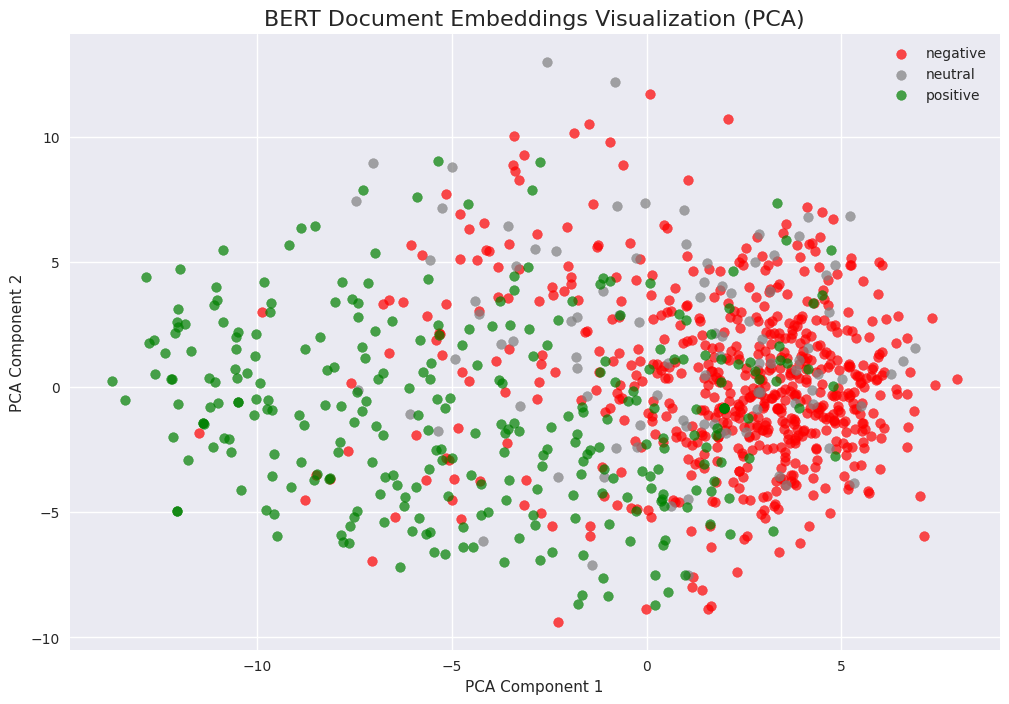

Explained variance ratio: [0.12363976 0.06891304]


In [22]:
# Analyze BERT embeddings
# Sample data for visualization
sample_size = 1000
if len(bert_embeddings) > sample_size:
    indices = np.random.choice(len(bert_embeddings), sample_size, replace=False)
    sample_bert = bert_embeddings[indices]
    sample_labels_bert = sentiment_labels[indices]
else:
    sample_bert = bert_embeddings
    sample_labels_bert = sentiment_labels

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2, random_state=42)
bert_2d = pca.fit_transform(sample_bert)

# Create visualization
fig, ax = plt.subplots(figsize=(12, 8))

colors = {'negative': 'red', 'neutral': 'gray', 'positive': 'green'}
for sentiment in ['negative', 'neutral', 'positive']:
    mask = sample_labels_bert == sentiment
    ax.scatter(bert_2d[mask, 0], bert_2d[mask, 1], 
               c=colors[sentiment], label=sentiment, alpha=0.7)

ax.set_title('BERT Document Embeddings Visualization (PCA)', fontsize=16)
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.legend()
plt.show()

print(f"Explained variance ratio: {pca.explained_variance_ratio_}")

## 4. Feature Comparison and Analysis

In [23]:
# Compare feature representations
feature_comparison = {
    'TF-IDF': {
        'dimensions': tfidf_features.shape[1],
        'sparsity': 1 - (tfidf_features.nnz / (tfidf_features.shape[0] * tfidf_features.shape[1])),
        'type': 'Sparse'
    },
    'Word2Vec': {
        'dimensions': doc_embeddings.shape[1],
        'sparsity': 0.0,
        'type': 'Dense'
    },
    'BERT': {
        'dimensions': bert_embeddings.shape[1],
        'sparsity': 0.0,
        'type': 'Dense'
    }
}

# Create comparison table
comparison_df = pd.DataFrame(feature_comparison).T
print("Feature Representation Comparison:")
print(comparison_df)

Feature Representation Comparison:
         dimensions  sparsity    type
TF-IDF         2008  0.992284  Sparse
Word2Vec        200       0.0   Dense
BERT            768       0.0   Dense


2025-09-01 17:00:00,631 - matplotlib.font_manager - WARNING - findfont: Font family 'Arial Unicode MS' not found.
2025-09-01 17:00:00,633 - matplotlib.font_manager - WARNING - findfont: Font family 'Arial Unicode MS' not found.
2025-09-01 17:00:00,635 - matplotlib.font_manager - WARNING - findfont: Font family 'Arial Unicode MS' not found.
2025-09-01 17:00:00,638 - matplotlib.font_manager - WARNING - findfont: Font family 'Arial Unicode MS' not found.
2025-09-01 17:00:00,655 - matplotlib.font_manager - WARNING - findfont: Font family 'Arial Unicode MS' not found.
2025-09-01 17:00:00,658 - matplotlib.font_manager - WARNING - findfont: Font family 'Arial Unicode MS' not found.
2025-09-01 17:00:00,660 - matplotlib.font_manager - WARNING - findfont: Font family 'Arial Unicode MS' not found.
2025-09-01 17:00:00,662 - matplotlib.font_manager - WARNING - findfont: Font family 'Arial Unicode MS' not found.
2025-09-01 17:00:00,664 - matplotlib.font_manager - WARNING - findfont: Font family 'Ari

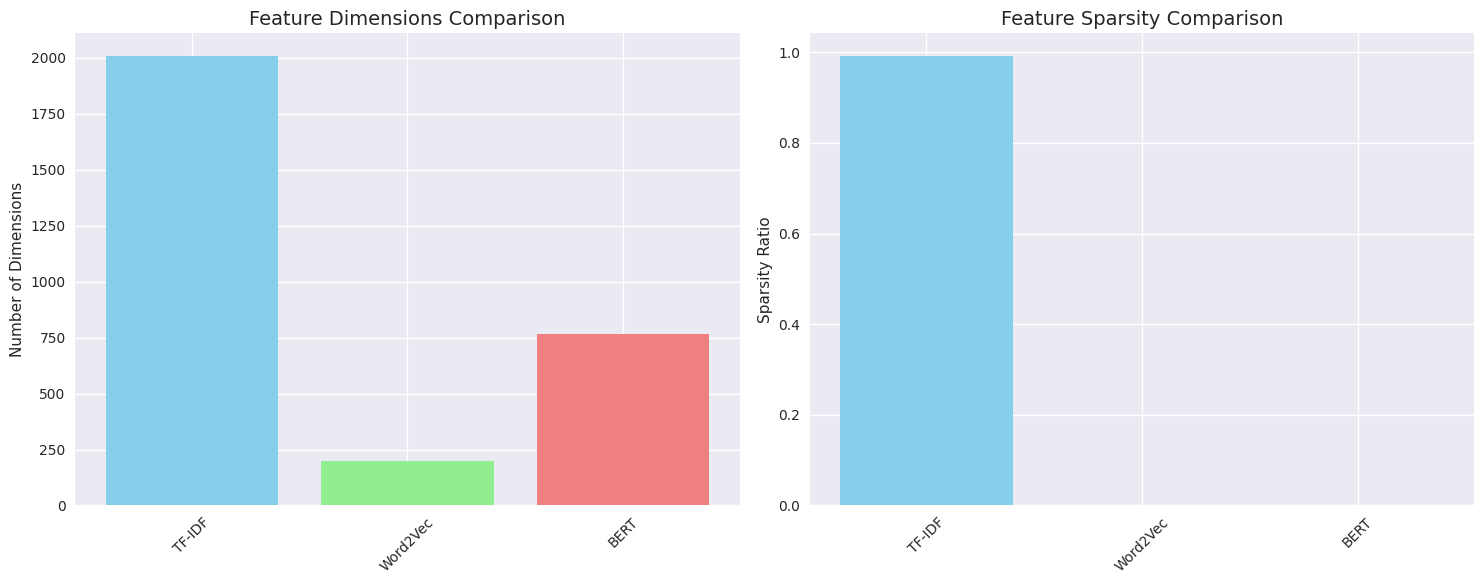

In [24]:
# Visualize feature comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Dimensions comparison
methods = list(feature_comparison.keys())
dimensions = [feature_comparison[method]['dimensions'] for method in methods]

axes[0].bar(methods, dimensions, color=['skyblue', 'lightgreen', 'lightcoral'])
axes[0].set_title('Feature Dimensions Comparison', fontsize=14)
axes[0].set_ylabel('Number of Dimensions')
axes[0].tick_params(axis='x', rotation=45)

# Sparsity comparison
sparsity = [feature_comparison[method]['sparsity'] for method in methods]

axes[1].bar(methods, sparsity, color=['skyblue', 'lightgreen', 'lightcoral'])
axes[1].set_title('Feature Sparsity Comparison', fontsize=14)
axes[1].set_ylabel('Sparsity Ratio')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 5. Feature Quality Analysis

In [25]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

def analyze_feature_quality(features, labels, feature_name):
    """Analyze feature quality using clustering and silhouette score"""
    
    # Convert sparse matrix to dense if needed
    if hasattr(features, 'toarray'):
        features_dense = features.toarray()
    else:
        features_dense = features
    
    # Apply K-means clustering
    n_clusters = len(np.unique(labels))
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(features_dense)
    
    # Calculate silhouette score
    silhouette_avg = silhouette_score(features_dense, cluster_labels)
    
    return {
        'silhouette_score': silhouette_avg,
        'n_clusters': n_clusters,
        'feature_dimensions': features_dense.shape[1]
    }

# Analyze each feature representation
quality_analysis = {}

print("Analyzing TF-IDF features...")
quality_analysis['TF-IDF'] = analyze_feature_quality(tfidf_features, sentiment_labels, 'TF-IDF')

print("Analyzing Word2Vec features...")
quality_analysis['Word2Vec'] = analyze_feature_quality(doc_embeddings, sentiment_labels, 'Word2Vec')

print("Analyzing BERT features...")
quality_analysis['BERT'] = analyze_feature_quality(bert_embeddings, sentiment_labels, 'BERT')

# Display results
quality_df = pd.DataFrame(quality_analysis).T
print("\nFeature Quality Analysis:")
print(quality_df)

Analyzing TF-IDF features...
Analyzing Word2Vec features...
Analyzing BERT features...

Feature Quality Analysis:
          silhouette_score  n_clusters  feature_dimensions
TF-IDF            0.009592         3.0              2008.0
Word2Vec          0.810301         3.0               200.0
BERT              0.049911         3.0               768.0


2025-09-01 17:00:11,902 - matplotlib.font_manager - WARNING - findfont: Font family 'Arial Unicode MS' not found.
2025-09-01 17:00:11,904 - matplotlib.font_manager - WARNING - findfont: Font family 'Arial Unicode MS' not found.
2025-09-01 17:00:11,907 - matplotlib.font_manager - WARNING - findfont: Font family 'Arial Unicode MS' not found.
2025-09-01 17:00:11,909 - matplotlib.font_manager - WARNING - findfont: Font family 'Arial Unicode MS' not found.
2025-09-01 17:00:11,925 - matplotlib.font_manager - WARNING - findfont: Font family 'Arial Unicode MS' not found.
2025-09-01 17:00:11,929 - matplotlib.font_manager - WARNING - findfont: Font family 'Arial Unicode MS' not found.
2025-09-01 17:00:11,931 - matplotlib.font_manager - WARNING - findfont: Font family 'Arial Unicode MS' not found.
2025-09-01 17:00:11,933 - matplotlib.font_manager - WARNING - findfont: Font family 'Arial Unicode MS' not found.
2025-09-01 17:00:11,935 - matplotlib.font_manager - WARNING - findfont: Font family 'Ari

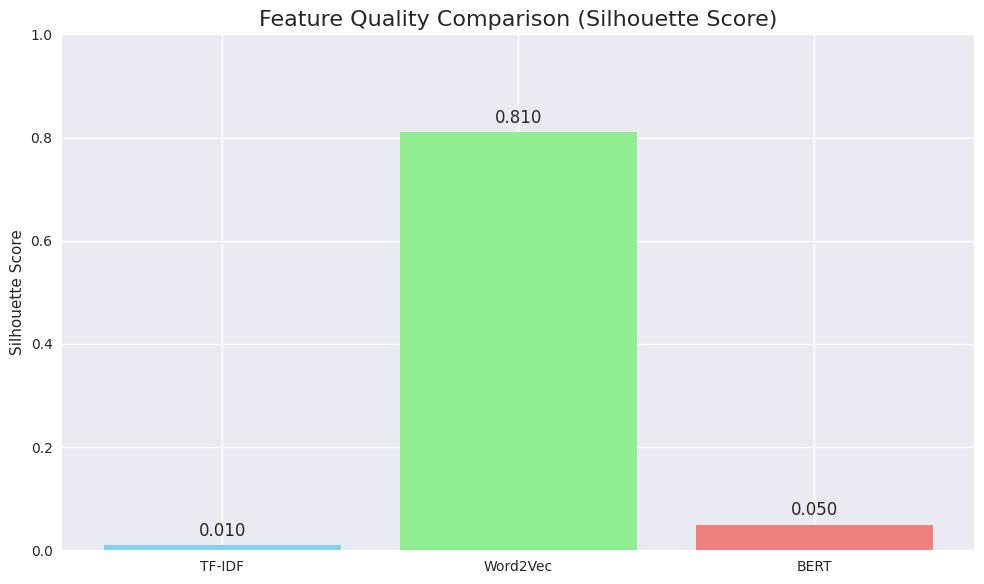

In [26]:
# Visualize quality metrics
fig, ax = plt.subplots(figsize=(10, 6))

methods = list(quality_analysis.keys())
silhouette_scores = [quality_analysis[method]['silhouette_score'] for method in methods]

bars = ax.bar(methods, silhouette_scores, color=['skyblue', 'lightgreen', 'lightcoral'])
ax.set_title('Feature Quality Comparison (Silhouette Score)', fontsize=16)
ax.set_ylabel('Silhouette Score')
ax.set_ylim(0, 1)

# Add value labels on bars
for bar, score in zip(bars, silhouette_scores):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{score:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## 6. Feature Selection and Dimensionality Reduction

In [27]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import TruncatedSVD

# Feature selection for TF-IDF
def select_best_features(features, labels, k=1000):
    """Select best features using statistical tests"""
    
    if hasattr(features, 'toarray'):
        features_dense = features.toarray()
    else:
        features_dense = features
    
    # Select k best features
    selector = SelectKBest(score_func=f_classif, k=min(k, features_dense.shape[1]))
    selected_features = selector.fit_transform(features_dense, labels)
    
    return selected_features, selector.scores_

# Apply feature selection to TF-IDF
print("Selecting best TF-IDF features...")
selected_tfidf, feature_scores = select_best_features(tfidf_features, sentiment_labels, k=1000)

print(f"Selected TF-IDF features shape: {selected_tfidf.shape}")
print(f"Feature selection scores range: {feature_scores.min():.2f} - {feature_scores.max():.2f}")

Selecting best TF-IDF features...
Selected TF-IDF features shape: (1688, 1000)
Feature selection scores range: 0.01 - 186.74


In [28]:
# Dimensionality reduction for dense features
def reduce_dimensions(features, n_components=100):
    """Reduce dimensions using PCA or SVD"""
    
    if hasattr(features, 'toarray'):
        # Use SVD for sparse matrices
        svd = TruncatedSVD(n_components=min(n_components, features.shape[1]), random_state=42)
        reduced_features = svd.fit_transform(features)
        explained_variance = svd.explained_variance_ratio_.sum()
    else:
        # Use PCA for dense matrices
        pca = PCA(n_components=min(n_components, features.shape[1]), random_state=42)
        reduced_features = pca.fit_transform(features)
        explained_variance = pca.explained_variance_ratio_.sum()
    
    return reduced_features, explained_variance

# Reduce dimensions for Word2Vec and BERT
print("Reducing Word2Vec dimensions...")
reduced_w2v, w2v_variance = reduce_dimensions(doc_embeddings, n_components=100)

print("Reducing BERT dimensions...")
reduced_bert, bert_variance = reduce_dimensions(bert_embeddings, n_components=100)

print(f"Reduced Word2Vec shape: {reduced_w2v.shape}, Explained variance: {w2v_variance:.3f}")
print(f"Reduced BERT shape: {reduced_bert.shape}, Explained variance: {bert_variance:.3f}")

Reducing Word2Vec dimensions...
Reducing BERT dimensions...
Reduced Word2Vec shape: (1688, 100), Explained variance: 1.000
Reduced BERT shape: (1688, 100), Explained variance: 0.837


## 7. Feature Engineering Summary and Recommendations

In [29]:
# Create comprehensive feature engineering summary
feature_summary = {
    'TF-IDF': {
        'Original_Dimensions': tfidf_features.shape[1],
        'Selected_Dimensions': selected_tfidf.shape[1],
        'Sparsity': 1 - (tfidf_features.nnz / (tfidf_features.shape[0] * tfidf_features.shape[1])),
        'Quality_Score': quality_analysis['TF-IDF']['silhouette_score'],
        'Pros': ['Interpretable', 'Fast', 'Good for sparse data'],
        'Cons': ['High dimensionality', 'No semantic meaning']
    },
    'Word2Vec': {
        'Original_Dimensions': doc_embeddings.shape[1],
        'Reduced_Dimensions': reduced_w2v.shape[1],
        'Sparsity': 0.0,
        'Quality_Score': quality_analysis['Word2Vec']['silhouette_score'],
        'Pros': ['Semantic meaning', 'Dense representation', 'Word similarities'],
        'Cons': ['Fixed vocabulary', 'No context']
    },
    'BERT': {
        'Original_Dimensions': bert_embeddings.shape[1],
        'Reduced_Dimensions': reduced_bert.shape[1],
        'Sparsity': 0.0,
        'Quality_Score': quality_analysis['BERT']['silhouette_score'],
        'Pros': ['Contextual', 'State-of-the-art', 'Rich semantics'],
        'Cons': ['Computationally expensive', 'Large model size']
    }
}

# Display summary
summary_df = pd.DataFrame(feature_summary).T
print("Feature Engineering Summary:")
print(summary_df[['Original_Dimensions', 'Reduced_Dimensions', 'Sparsity', 'Quality_Score']])

print("\nPros and Cons:")
for method, info in feature_summary.items():
    print(f"\n{method}:")
    print(f"  Pros: {', '.join(info['Pros'])}")
    print(f"  Cons: {', '.join(info['Cons'])}")

Feature Engineering Summary:
         Original_Dimensions Reduced_Dimensions  Sparsity Quality_Score
TF-IDF                  2008                NaN  0.992284      0.009592
Word2Vec                 200                100       0.0      0.810301
BERT                     768                100       0.0      0.049911

Pros and Cons:

TF-IDF:
  Pros: Interpretable, Fast, Good for sparse data
  Cons: High dimensionality, No semantic meaning

Word2Vec:
  Pros: Semantic meaning, Dense representation, Word similarities
  Cons: Fixed vocabulary, No context

BERT:
  Pros: Contextual, State-of-the-art, Rich semantics
  Cons: Computationally expensive, Large model size


In [32]:
import numpy as np
import json

def convert_numpy_types(obj):
    """Convert numpy types to Python native types for JSON serialization"""
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {convert_numpy_types(key): convert_numpy_types(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy_types(item) for item in obj]
    elif isinstance(obj, tuple):
        return tuple(convert_numpy_types(item) for item in obj)
    else:
        return obj

In [ ]:
# Save feature engineering results
import json
from datetime import datetime

# Prepare results for saving
feature_engineering_results = {
    'timestamp': datetime.now().isoformat(),
    'dataset_info': {
        'total_samples': len(df),
        'sentiment_distribution': df['sentiment_label'].value_counts().to_dict()
    },
    'feature_analysis': {
        'tfidf': {
            'original_dimensions': tfidf_features.shape[1],
            'selected_dimensions': selected_tfidf.shape[1],
            'sparsity': 1 - (tfidf_features.nnz / (tfidf_features.shape[0] * tfidf_features.shape[1])),
            'quality_score': quality_analysis['TF-IDF']['silhouette_score']
        },
        'word2vec': {
            'original_dimensions': doc_embeddings.shape[1],
            'reduced_dimensions': reduced_w2v.shape[1],
            'sparsity': 0.0,
            'quality_score': quality_analysis['Word2Vec']['silhouette_score'],
            'explained_variance': w2v_variance
        },
        'bert': {
            'original_dimensions': bert_embeddings.shape[1],
            'reduced_dimensions': reduced_bert.shape[1],
            'sparsity': 0.0,
            'quality_score': quality_analysis['BERT']['silhouette_score'],
            'explained_variance': bert_variance
        }
    },
    'recommendations': {
        'best_overall': 'BERT' if quality_analysis['BERT']['silhouette_score'] > max(quality_analysis['TF-IDF']['silhouette_score'], quality_analysis['Word2Vec']['silhouette_score']) else 'TF-IDF' if quality_analysis['TF-IDF']['silhouette_score'] > quality_analysis['Word2Vec']['silhouette_score'] else 'Word2Vec',
        'best_for_speed': 'TF-IDF',
        'best_for_interpretability': 'TF-IDF',
        'best_for_semantics': 'BERT'
    }
}

# Save results
results_path = RESULTS_DIR / 'reports' / 'feature_engineering_analysis.json'
results_path.parent.mkdir(parents=True, exist_ok=True)

feature_engineering_results = convert_numpy_types(feature_engineering_results)

# Now save to JSON
with open(results_path, 'w', encoding='utf-8') as f:
    json.dump(feature_engineering_results, f, indent=2, ensure_ascii=False)

print(f"Feature engineering results saved to: {results_path}")
print("\nFeature Engineering Analysis Complete!")
print("\nKey Findings:")
print(f"- Best overall feature representation: {feature_engineering_results['recommendations']['best_overall']}")
print(f"- TF-IDF quality score: {quality_analysis['TF-IDF']['silhouette_score']:.3f}")
print(f"- Word2Vec quality score: {quality_analysis['Word2Vec']['silhouette_score']:.3f}")
print(f"- BERT quality score: {quality_analysis['BERT']['silhouette_score']:.3f}")

TypeError: Object of type float32 is not JSON serializable